# Logistic Regression

# Implementation

# 1. Logistic Regression with statsmodel
We'll be using the same dataset as UCLA's Logit Regression tutorial to explore logistic regression in Python. Our goal will be to identify the various factors that may influence admission into graduate school.

The dataset contains several columns which we can use as predictor variables:

   * gpa
   * gre score
   * rank or prestige of an applicant's undergraduate alma mater
   * The fourth column, admit, is our binary target variable. It indicates whether or not a candidate was admitted our not.

In [2]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [14]:
# read the data in
df = pd.read_csv("./data/binary.csv")
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### Data Preprocessing

In [15]:
# rename the 'rank' column because there is also a DataFrame method called 'rank'
df.columns = ["admit", "gre", "gpa", "prestige"]
df.head()

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### Summary Statistics & Looking at the data
Now that we've got everything loaded into Python and named appropriately let's take a look at the data. We can use the pandas function describe to give us a summarized view of everything. There's also function for calculating the standard deviation, std.

A feature I really like in pandas is the pivot_table/crosstab aggregations. crosstab makes it really easy to do multidimensional frequency tables. You might want to play around with this to look at different cuts of the data.

In [5]:
df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [6]:
df.isnull().sum()     # if all 0 means no null value in any column

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B1F04E0>,
      dtype=object)

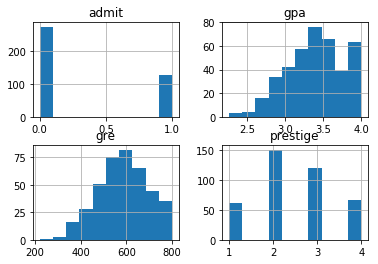

In [7]:
df.hist()   # will show the distribution of each column

#as admit binary--our target
# prestige having only four categories(1 to 4)

In [8]:
#checking of how many admitted or not admitted
category= df['admit'].value_counts().to_frame()

category.index.name= "Status"
 
category.rename({0: "Not Admitted", 1: 'Admitted'})

,admit
Status,
Not Admitted,273
Admitted,127


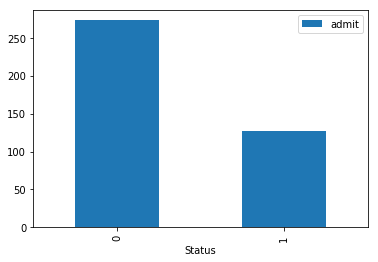

In [9]:

category.plot(kind='bar')



Text(0,0.5,'Numbers')

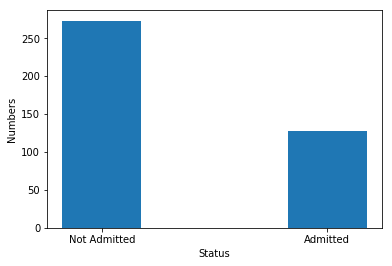

In [10]:
#or can plot like below
import matplotlib.pyplot as plt
x=len(category)
N=np.arange(x)
target= category['admit']
width = 0.35
plt.bar(N,target, width)
plt.xticks(N,('Not Admitted','Admitted'))
plt.xlabel("Status")
plt.ylabel("Numbers")

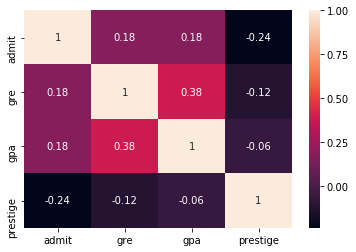

In [11]:
#dispaly of correlation matrix for colinearity
import seaborn as sns
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

###### showing gpa and gre contributing more(0.18 each) , and also have higest colinearity 0.38 hence selecting both together would not be good choice

### dummy variables : as prestige having only 4 categories so can be binarified
pandas gives you a great deal of control over how categorical variables are represented. We're going dummify the "prestige" column using get_dummies.

get_dummies creates a new DataFrame with binary indicator variables for each category/option in the column specified. In this case, prestige has four levels: 1, 2, 3 and 4 (1 being most prestigious). When we call get_dummies, we get a dataframe with four columns, each of which describes one of those levels.

In [12]:
# dummify rank
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [13]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,admit,gre,gpa,prestige_2,prestige_3,prestige_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [16]:
# manually add the intercept
data['intercept'] = 1.0

Once that's done, we merge the new dummy columns into the original dataset and get rid of the prestige column which we no longer need.

Lastly we're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [17]:
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0,1,0,1.0
1,1,660,3.67,0,1,0,1.0
2,1,800,4.00,0,0,0,1.0
3,1,640,3.19,0,0,1,1.0
4,0,520,2.93,0,0,1,1.0


### Performing the regression
Actually doing the Logistic Regression is quite simple. Specify the column containing the variable you're trying to predict followed by the columns that the model should use to make the prediction.

In our case we'll be predicting the admit column using gre, gpa, and the prestige dummy variables prestige_2, prestige_3 and prestige_4. We're going to treat prestige_1 as our baseline and exclude it from our fit. This is done to prevent multicollinearity, or the dummy variable trap caused by including a dummy variable for every single category.

In [20]:
train_cols = data.columns[1:]
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(data['admit'], data[train_cols])

# fit the model
result = logit.fit()
result

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


Since we're doing a logistic regression, we're going to use the statsmodels Logit function. For details on other models available in statsmodels, check out their docs here.

### Interpreting the results
One of my favorite parts about statsmodels is the summary output it gives. If you're coming from R, I think you'll like the output and find it very familiar too.

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 25 Aug 2019   Pseudo R-squ.:                 0.08292
Time:                        10:34:26   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038       0.000       0.004
gpa            0.8040      0.332      2.423      0.015       0.154       1.454
prestige_2    -0.6754      0.316     -2.134      0.033      -1.296      -0.055
prestige_3    -1.3402      0.345     -3.881      0.000      -2.017      -0.663
prestige_4    -1.5515      0.418     -3.713      0.000      -2.370      -0.733
intercept     -3.9900      1.140     -3.500      0.000      -6.224      -1.756
==============================================================================
"""

# 2. Logistic Regression with scikit-learn



## Dataset

The dataset I chose is the [affairs dataset](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html) that comes with [Statsmodels](http://statsmodels.sourceforge.net/). It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a [1978 paper](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf) from the Journal of Political Economy.

## Description of Variables

The dataset contains 6366 observations of 9 variables:

* `rate_marriage`: woman's rating of her marriage (1 = very poor, 5 = very good)
* `age`: woman's age
* `yrs_married`: number of years married
* `children`: number of children
* `religious`: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* `educ`: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* `occupation`: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* `occupation_husb`: husband's occupation (same coding as above)
* `affairs`: time spent in extra-marital affairs

## Problem Statement

I decided to treat this as a classification problem by creating a new binary variable `affair` (did the woman have at least one affair?) and trying to predict the classification for each woman.


## Import modules

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Pre-Processing¶

In [24]:
# load dataset
dta = sm.datasets.fair.load_pandas().data
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [25]:
dta.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


In [26]:
dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
rate_marriage      6366 non-null float64
age                6366 non-null float64
yrs_married        6366 non-null float64
children           6366 non-null float64
religious          6366 non-null float64
educ               6366 non-null float64
occupation         6366 non-null float64
occupation_husb    6366 non-null float64
affairs            6366 non-null float64
dtypes: float64(9)
memory usage: 447.7 KB


In [29]:
dta.isnull().sum()   # no column having null

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C00A828>,
      dtype=object)

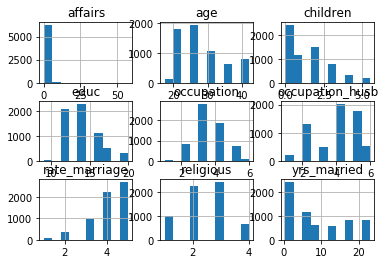

In [30]:
dta.hist()

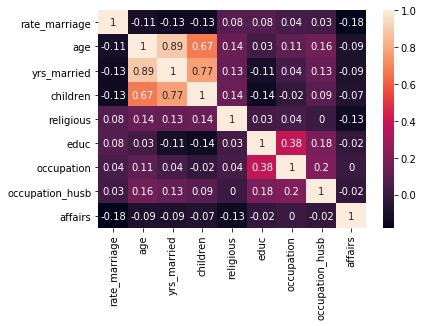

In [31]:
#heat map plot for knowing contribution and colinearity
#dispaly of correlation matrix for colinearity
import seaborn as sns
correlation_matrix = dta.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [32]:
# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

In [38]:
dta.tail(10)    # affair == 1 means having affair, 0 means no

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
6356,5.0,32.0,13.0,3.0,3.0,12.0,3.0,5.0,0.0,0
6357,5.0,32.0,13.0,4.0,2.0,14.0,4.0,4.0,0.0,0
6358,3.0,27.0,6.0,2.0,4.0,14.0,3.0,1.0,0.0,0
6359,4.0,22.0,2.5,0.0,3.0,16.0,5.0,5.0,0.0,0
6360,5.0,22.0,2.5,0.0,2.0,14.0,3.0,3.0,0.0,0
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.0,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.0,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.0,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.0,0
6365,4.0,22.0,2.5,0.0,2.0,16.0,2.0,4.0,0.0,0


## Data Exploration

In [44]:
dta.groupby('affair').sum()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,18674.0,122449.0,34458.0,5343.0,10802.0,61775.0,14687.0,16535.0,0.000000
1,7488.0,62692.5,22896.0,3549.5,4643.0,28685.0,7111.0,7975.0,4490.410172


In [45]:
dta.groupby('affair').count()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4313,4313,4313,4313,4313,4313,4313,4313,4313
1,2053,2053,2053,2053,2053,2053,2053,2053,2053


In [46]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the rate_marriage variable.

In [49]:
df_rate_marrige=dta.groupby('rate_marriage').mean()
type(df_rate_marrige)

pandas.core.frame.DataFrame

In [51]:
df_rate_marrige

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in `age`, `yrs_married`, and `children` appears to correlate with a declining marriage rating.

## Data Visualization

In [53]:
# show plots in the notebook
%matplotlib inline

Let's start with histograms of education and marriage rating.

Text(0,0.5,'Frequency')

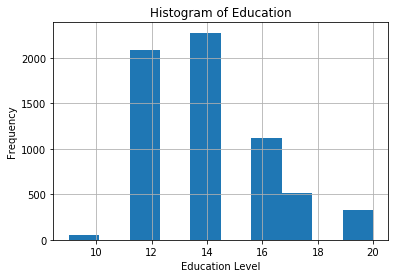

In [54]:
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

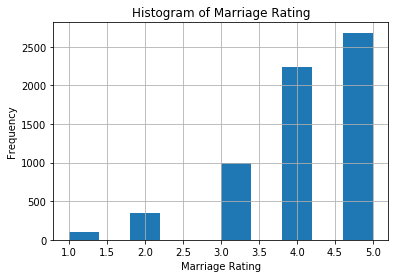

In [55]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

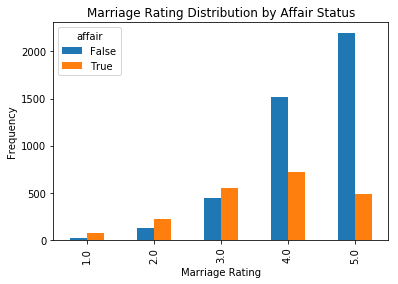

In [56]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0,0.5,'Percentage')

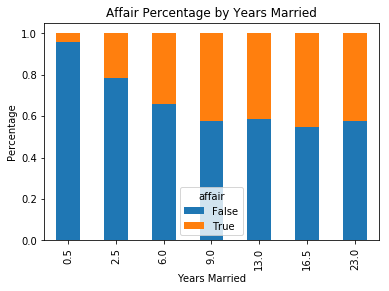

In [57]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

## Prepare Data for Logistic Regression

To prepare the data, I want to add an intercept column as well as dummy variables for `occupation` and `occupation_husb`, since I'm treating them as categorial variables. The dmatrices function from the [patsy module](http://patsy.readthedocs.org/en/latest/) can do that using formula language.

In [59]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
X.columns

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')

In [61]:
y.columns

Index(['affair'], dtype='object')

The column names for the dummy variables are ugly, so let's rename those.

In [63]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [65]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0


In [67]:
y.head()

,affair
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable. **/or we can take it into a series y= dta['affair']**

In [68]:
# flatten y into a 1-D array
y = np.ravel(y)
y

array([1., 1., 1., ..., 0., 0., 0.])

# Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [69]:
# instantiate a logistic regression model, and fit with X and y 
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7258875274897895

73% accuracy seems good, but what's the null error rate?

In [70]:
# what percentage had affairs?
y.mean()

0.3224945020420987

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

Let's examine the coefficients to see what we learn.

In [71]:
# examine the coefficients
X.columns, np.transpose(model.coef_)

(Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
        'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
        'age', 'yrs_married', 'children', 'religious', 'educ'],
       dtype='object'), array([[ 1.48983606],
        [ 0.1880664 ],
        [ 0.49894812],
        [ 0.25066814],
        [ 0.839008  ],
        [ 0.83390825],
        [ 0.19063622],
        [ 0.2978329 ],
        [ 0.16140914],
        [ 0.18777109],
        [ 0.19401647],
        [-0.70311973],
        [-0.05841813],
        [ 0.10567669],
        [ 0.01691983],
        [-0.37113512],
        [ 0.00401584]]))

In [72]:
for item in zip(X.columns, np.transpose(model.coef_)):
    print(item)

('Intercept', array([1.48983606]))
('occ_2', array([0.1880664]))
('occ_3', array([0.49894812]))
('occ_4', array([0.25066814]))
('occ_5', array([0.839008]))
('occ_6', array([0.83390825]))
('occ_husb_2', array([0.19063622]))
('occ_husb_3', array([0.2978329]))
('occ_husb_4', array([0.16140914]))
('occ_husb_5', array([0.18777109]))
('occ_husb_6', array([0.19401647]))
('rate_marriage', array([-0.70311973]))
('age', array([-0.05841813]))
('yrs_married', array([0.10567669]))
('children', array([0.01691983]))
('religious', array([-0.37113512]))
('educ', array([0.00401584]))



Increases in marriage rating and religiousness correspond to a decrease in the likelihood of having an affair. For both the wife's occupation and the husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive.

## Model Evaluation Using a Validation Set

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [76]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [78]:
# predict class labels for the test set
predicted = model2.predict(X_test)
predicted

array([1., 0., 0., ..., 0., 0., 0.])

In [80]:
# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[0.35142488, 0.64857512],
       [0.90952576, 0.09047424],
       [0.72576603, 0.27423397],
       ...,
       [0.55736751, 0.44263249],
       [0.81213933, 0.18786067],
       [0.74729595, 0.25270405]])

As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.

Now let's generate some evaluation metrics.

In [81]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.7298429319371728
0.7459619860896347


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

We can also see the confusion matrix and a classification report with other metrics.

In [83]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



# Model Evaluation Using Cross-Validation
Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [85]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
scores, scores.mean()

(array([0.72100313, 0.70219436, 0.73824451, 0.70597484, 0.70597484,
        0.72955975, 0.7327044 , 0.70440252, 0.75157233, 0.75      ]),
 0.7241630685514876)

Looks good. It's still performing at 73% accuracy.

## Predicting the Probability of an Affair

Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [87]:
model.predict_proba(np.array([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
                              16]]))

array([[0.7747227, 0.2252773]])

 0.2252773======~23% probabilty only